# U-Net: For Organoid image segmentation

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.python.keras.backend as K
from tensorflow.python.keras.models import load_model
# from tensorflow.python.keras.layers import Conv2D, MaxPool2D, Dropout, Conv2DTranspose, concatenate, Input

## Data preparation
Dataset images along with  corresponding segmentation masks (ground truth labels) indicating the areas of interest (e.g., boundaries, objects, etc.).

In [2]:
def resize_normalize(img_path, target_size=(128, 128)):
    img = Image.open(img_path)
    img = img.resize(target_size)  # Resize to the target size
    img = np.array(img) / 255.0  # Normalize pixel values (assuming 0-255 range)
    return img

In [3]:
def process_dataset(source_folder):
    images = []

    for file_name in os.listdir(source_folder):
        file_path = os.path.join(source_folder, file_name)
        if os.path.isfile(file_path):
            image = resize_normalize(file_path)
            images.append(image)

    images = np.array(images)
    print(images.shape)
    return images

In [4]:

# The data for training contains 3625 512*512 images
test_images = process_dataset('dataset/test/')  # 544
valid_images = process_dataset('dataset/valid/')  # 544
train_images = process_dataset('dataset/train/')  # 2537

test_mask_images = process_dataset('dataset/test_mask/')  # 544
valid_mask_images = process_dataset('dataset/valid_mask/')  # 544
train_mask_images = process_dataset('dataset/train_mask/')  # 2537

(544, 128, 128, 3)
(544, 128, 128, 3)
(2537, 128, 128, 3)
(544, 128, 128, 3)
(544, 128, 128, 3)
(2537, 128, 128, 3)


## U-Net model

Contracting path (Encoder containing down-sampling steps):
* Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels.
* The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to down-sample the image and extract its features. In detail, it consists of the repeated application of two 3 x 3 same padding convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for down-sampling. At each down-sampling step, the number of feature channels is doubled.
* Crop function: This step crops the image from the contracting path and concatenates it to the current image on the expanding path to create a skip connection.

Expanding path (Decoder containing up-sampling steps):
* The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually.
* In detail, each step in the expanding path up-samples the feature map, followed by a 2 x 2 convolution (the transposed convolution). This transposed convolution halves the number of feature channels, while growing the height and width of the image.
* Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. You need to perform cropping to handle the loss of border pixels in every convolution.

Final Feature Mapping Block:
* In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used, so when you use 1x1 convolutions, you can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, you can reduce the channel dimensions to have one layer per class.

The U-Net network has 23 convolutional layers in total.

In [5]:
def double_conv_block(input_image, n_filters):

    # Convolution with 3x3 filter followed by ReLU activation
    conv_relu_one = tf.keras.layers.Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(input_image)
    conv_relu_two = tf.keras.layers.Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(conv_relu_one)

    return conv_relu_two

In [6]:
def down_sample(input_image, n_filters):
    """
    Encoder
    Two 3x3 convolutions with ReLU activation functions, which perform feature extraction,
    and a 2x2 max-pooling layer for down-sampling.
    """

    conv_relu_two = double_conv_block(input_image, n_filters)
    # Max Pooling with 2x2 filter
    max_pool = tf.keras.layers.MaxPool2D(2)(conv_relu_two)
    max_pool = tf.keras.layers.Dropout(0.3)(max_pool)

    return conv_relu_two, max_pool

In [7]:
def up_sample(input_image, conv_features, n_filters):
    """
    Decoder
    Comprises up-convolutions (transposed convolutions) that increase the spatial resolution of the feature maps.
    Each step in this path involves an up-convolutional layer followed by concatenation with the corresponding feature maps from the contracting path. This step helps in preserving spatial information and finer details.
    After concatenation, there are two 3x3 convolutions with ReLU activation functions to further process the combined features.
    """
    
    segmentation_map = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(input_image)
    # Copy and crop the skip features
    segmentation_map = tf.keras.layers.concatenate([segmentation_map, conv_features])
    segmentation_map = tf.keras.layers.Dropout(0.3)(segmentation_map)
    segmentation_map = double_conv_block(segmentation_map, n_filters)

    return segmentation_map

In [8]:
def build_unet_model():

    # inputs
    inputs = tf.keras.layers.Input(shape=(128, 128, 3))

    # encoder: Contracting path - down sample
    conv_relu_two1, max_pool1 = down_sample(inputs, 64)
    conv_relu_two2, max_pool2 = down_sample(max_pool1, 128)
    conv_relu_two3, max_pool3 = down_sample(max_pool2, 256)
    conv_relu_two4, max_pool4 = down_sample(max_pool3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(max_pool4, 1024)

    # decoder: Expanding path - up sample
    up_conv1 = up_sample(bottleneck, conv_relu_two4, 512)
    up_conv2 = up_sample(up_conv1, conv_relu_two3, 256)
    up_conv3 = up_sample(up_conv2, conv_relu_two2, 128)
    up_conv4 = up_sample(up_conv3, conv_relu_two1, 64)

    """
    A 1x1 convolutional layer with a softmax activation function (for multi-class segmentation) or a 
    sigmoid activation function (for binary segmentation) is used to produce the final segmentation map.
    """
    # The output has three channels corresponding to the 2 classes that the model will classify each pixel for:
    # background, foreground object
    segmentation_map = tf.keras.layers.Conv2D(3, 1, padding="same", activation="sigmoid")(up_conv4)

    # unet model with Keras Functional API
    u_net = tf.keras.Model(inputs, segmentation_map, name="U-Net")

    return u_net

In [9]:
unet_model = build_unet_model()
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [10]:
tf.keras.utils.plot_model(unet_model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Metrics to Evaluate your Semantic Segmentation Model

1. Pixel Accuracy
2. Intersection-Over-Union (Jaccard Index)
3. Dice Coefficient (F1 Score)

In [11]:
def mean_iou(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * K.round(y_pred)))
    union = K.sum(y_true) + K.sum(K.round(y_pred)) - intersection
    iou = intersection / (union + K.epsilon())
    return iou



def dice_coefficient(y_true, y_pred):
    numerator = 2 * K.sum(y_true * y_pred)
    denominator = K.sum(y_true) + K.sum(y_pred)
    dice = numerator / (denominator + K.epsilon())
    return dice



# number of pixels that are classified correctly in the generated segmentation mask
def pixel_wise_accuracy(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

In [12]:
unet_model.compile(optimizer='adam', loss="binary_crossentropy", metrics=[mean_iou, dice_coefficient, pixel_wise_accuracy])

history = unet_model.fit(train_images, train_mask_images, epochs=5, batch_size=32, validation_data=(valid_images, valid_mask_images))

Epoch 1/5
80/80 [==============================] - 1637s 20s/step - loss: 1.0182 - mean_iou: 0.5149 - dice_coefficient: 0.4437 - pixel_wise_accuracy: 0.9340 - val_loss: 0.0158 - val_mean_iou: 0.9519 - val_dice_coefficient: 0.9670 - val_pixel_wise_accuracy: 0.9954
Epoch 2/5
80/80 [==============================] - 1329s 17s/step - loss: 0.0119 - mean_iou: 0.9616 - dice_coefficient: 0.9724 - pixel_wise_accuracy: 0.9967 - val_loss: 0.0079 - val_mean_iou: 0.9718 - val_dice_coefficient: 0.9808 - val_pixel_wise_accuracy: 0.9983
Epoch 3/5
80/80 [==============================] - 1336s 17s/step - loss: 0.0078 - mean_iou: 0.9717 - dice_coefficient: 0.9802 - pixel_wise_accuracy: 0.9983 - val_loss: 0.0073 - val_mean_iou: 0.9732 - val_dice_coefficient: 0.9816 - val_pixel_wise_accuracy: 0.9986
Epoch 4/5
80/80 [==============================] - 1331s 17s/step - loss: 0.0074 - mean_iou: 0.9728 - dice_coefficient: 0.9810 - pixel_wise_accuracy: 0.9985 - val_loss: 0.0071 - val_mean_iou: 0.9735 - val_dic

## Accuracy

In [13]:
test_results = unet_model.evaluate(test_images, test_mask_images)
test_loss = test_results[0]
print(f"Test Loss: {test_loss}")
test_accuracy = test_results[1]
print(f"Test Accuracy: {test_accuracy}")

17/17 [==============================] - 48s 3s/step - loss: 0.0068 - mean_iou: 0.9742 - dice_coefficient: 0.9823 - pixel_wise_accuracy: 0.9989
Test Loss: 0.006774312816560268
Test Accuracy: 0.9741820096969604


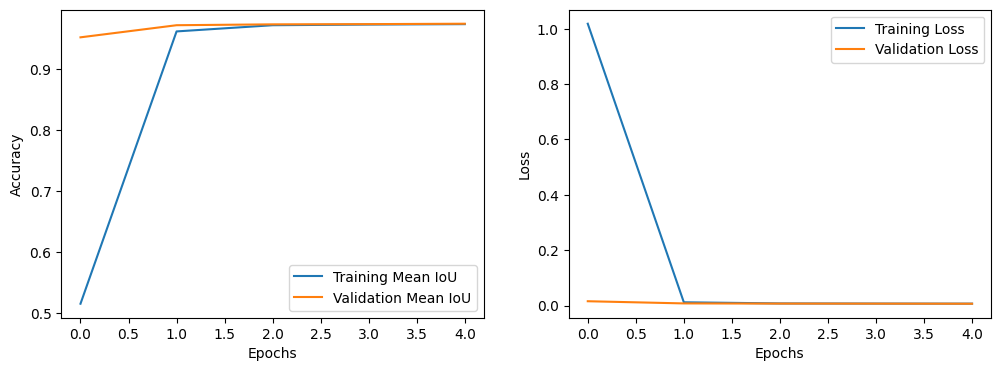

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['mean_iou'], label='Training Mean IoU')
plt.plot(history.history['val_mean_iou'], label='Validation Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Sample prediction

In [18]:
new_test_images = process_dataset('dataset/new_test/')
new_test_mask_images = process_dataset('dataset/new_test_mask/')

(3, 128, 128, 3)
(3, 128, 128, 3)


1/1 [==============================] - 1s 675ms/step


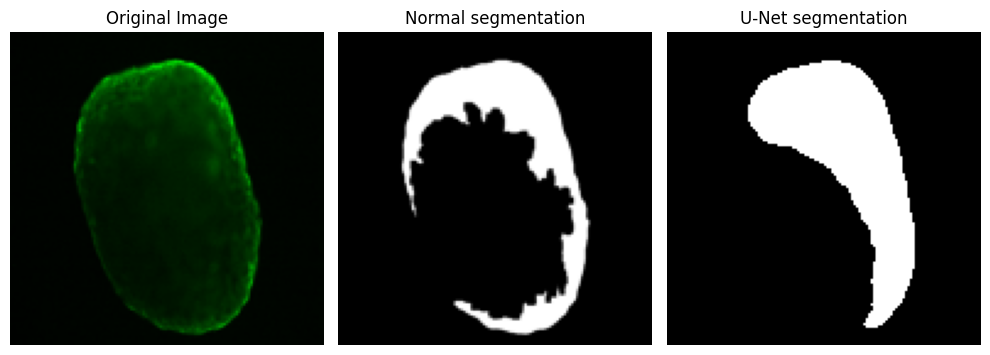

1/1 [==============================] - 0s 235ms/step


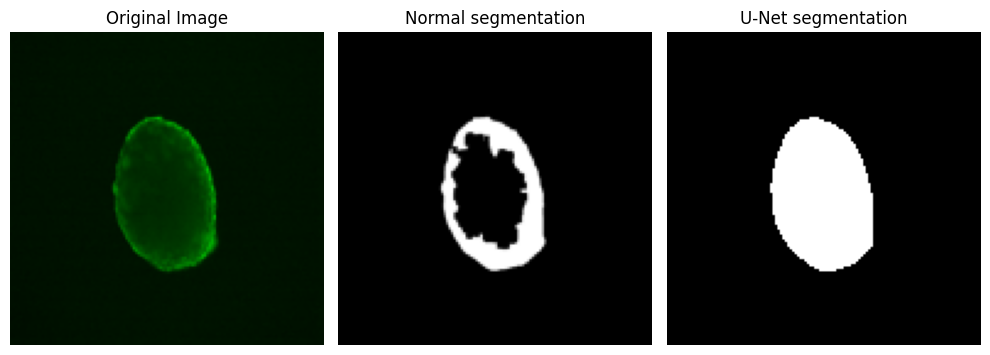

1/1 [==============================] - 0s 219ms/step


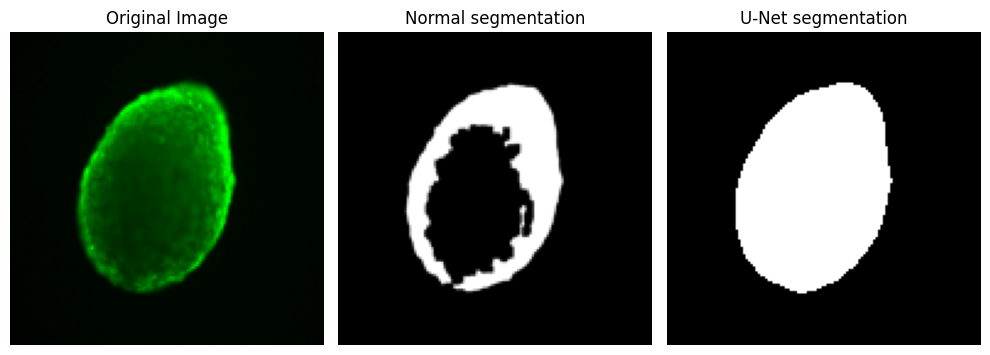

In [19]:
# Prediction

for i, contour in enumerate(new_test_images):
    sample_index = 0  # Change this index to visualize predictions on different test images
    plt.figure(figsize=(10, 5))
    
    # Original test image
    plt.subplot(1, 3, 1)
    plt.imshow(new_test_images[i])
    plt.title('Original Image')
    plt.axis('off')
    
    # Ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(new_test_mask_images[i])
    plt.title('Normal segmentation')
    plt.axis('off')
    
    # Model's predicted mask
    predictions = unet_model.predict(new_test_images[i][np.newaxis, ...])
    binary_mask = (predictions[0, :, :, 0] > 0.5).astype(np.uint8)  # Thresholding for a binary mask
    plt.subplot(1, 3, 3)
    plt.imshow(binary_mask, cmap='gray')  # Displaying as a grayscale image
    plt.title('U-Net segmentation')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

## Reuse of trained model

In [21]:
unet_model.save('saved_unet.keras')
loaded_model = load_model('saved_unet.h5')

# predictions = loaded_model.predict(input_data)

ValueError: Unknown optimizer: Custom>Adam. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.